In [1]:
import pandas as pd
import os

In [ ]:
# Group data into one csv file
file_names = [ '2021_incidents.csv', '2022_incidents.csv', '2023_incidents.csv']
dataframes_list = []

for file in file_names:
    if os.path.exists(file):
        # Read the CSV file
        df = pd.read_csv(file)
        # Add it to our list
        dataframes_list.append(df)
        print(f"Successfully loaded: {file} ({len(df)} rows)")
    else:
        print(f"Warning: File not found - {file}")


merged_df = pd.concat(dataframes_list, ignore_index=True)

# Save to a new CSV file
output_filename = 'merged_incidents.csv'
merged_df.to_csv(output_filename, index=False)

print(f"\nSuccess! Merged {len(dataframes_list)} files.")
print(f"Total rows: {len(merged_df)}")
print(f"Saved as: {output_filename}")


Successfully loaded: 2021_incidents.csv (485506 rows)
Successfully loaded: 2022_incidents.csv (329127 rows)
Successfully loaded: 2023_incidents.csv (149758 rows)

Success! Merged 3 files.
Total rows: 964391
Saved as: merged_incidents.csv


Running K-Means with k=50 on 149758 points...

Centroids and counts saved to: cluster_centroids_stats.csv
    Cluster_ID  Centroid_Latitude  Centroid_Longitude  Incident_Count
0            0          14.789273          101.553587             639
1            1          13.731548          100.611416           10704
2            2           7.198805          100.594839              67
3            3          13.669395          100.408807            9242
4            4          16.852664          100.299351              77
5            5          14.035836          100.633522            4143
6            6          13.442031          101.010763             862
7            7          11.477671           99.594826              35
8            8           7.946887           98.359969              66
9            9          13.801483          100.651815            7316
10          10          16.076107          102.511053              84
11          11          13.732620          100.737050 

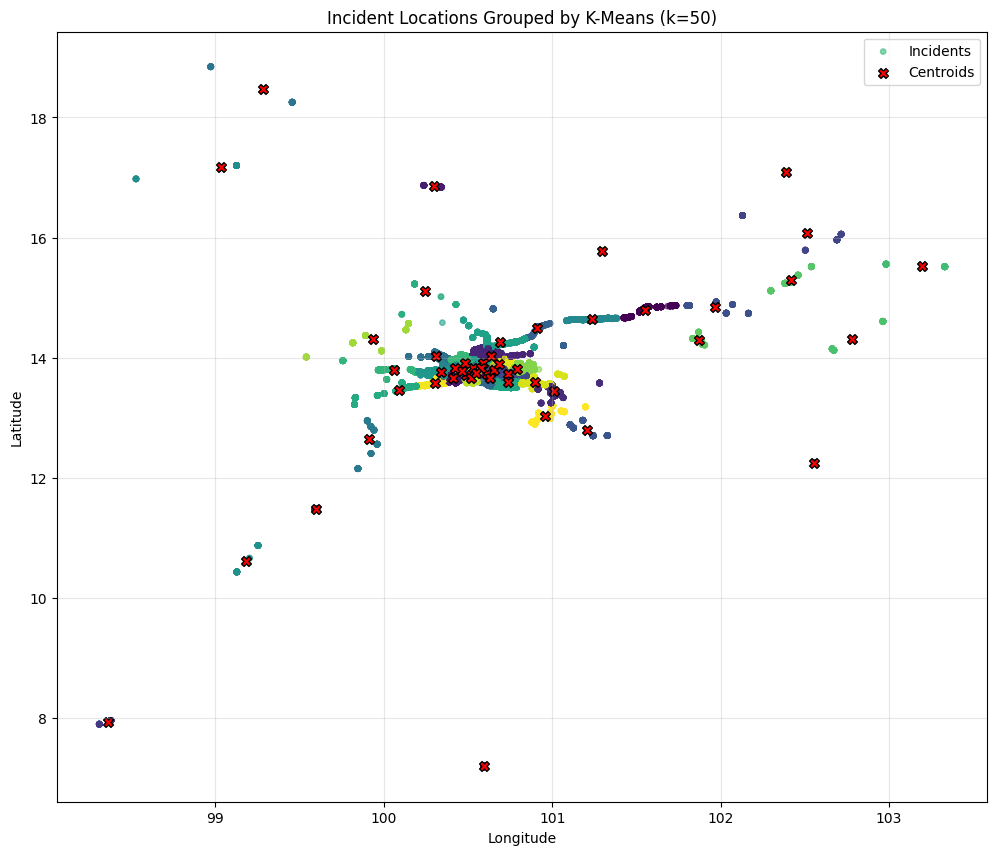

In [6]:
# Clustering
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def perform_clustering(filename, k=5):
    pd.read_csv(filename)

     # 1. Preprocess: Ensure lat/lon are numeric and drop NaNs
    location_cols = ['latitude', 'longitude']
    
    # Coerce to numeric, turning non-parsable strings into NaN
    for col in location_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Drop rows where lat or lon is NaN
    clean_data = df.dropna(subset=location_cols)
    
    if clean_data.empty:
        print("No valid location data found to cluster.")
        return

    # Extract just the coordinates for clustering
    # X column 0 = latitude, column 1 = longitude
    X = clean_data[location_cols]

    print(f"Running K-Means with k={k} on {len(X)} points...")
    
    # 2. Apply K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    
    # Get the cluster labels and add to dataframe
    labels = kmeans.labels_
    df.loc[X.index, 'cluster_group'] = labels
    
    # 3. Create Centroid Stats Dataframe (Requested Feature)
    # Get coordinates of the centers
    centers = kmeans.cluster_centers_
    
    # Count incidents per cluster
    # We use groupby size to ensure we get counts for all clusters present
    counts = df.groupby('cluster_group').size()
    
    stats_list = []
    for i in range(k):
        stats_list.append({
            'Cluster_ID': i,
            'Centroid_Latitude': centers[i][0],  # 0 is lat because X column 0 was lat
            'Centroid_Longitude': centers[i][1], # 1 is lon
            'Incident_Count': counts.get(i, 0)   # Get count or 0 if empty
        })
        
    stats_df = pd.DataFrame(stats_list)
    
    # Save the stats
    stats_filename = 'cluster_centroids_stats.csv'
    stats_df.to_csv(stats_filename, index=False)
    print(f"\nCentroids and counts saved to: {stats_filename}")
    print(stats_df)

    # 4. Visualize Results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X['longitude'], X['latitude'], 
                          c=labels, alpha=0.6, s=15, label='Incidents')
    
    plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, marker='X', 
                edgecolors='black', label='Centroids')
    
    plt.title(f'Incident Locations Grouped by K-Means (k={k})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    output_plot = 'incident_clusters_map.png'
    plt.savefig(output_plot)
    print(f"Cluster map saved to: {output_plot}")

    # 5. Save Full Data with Cluster IDs
    output_csv = 'incidents_with_clusters.csv'
    df.to_csv(output_csv, index=False)
    print(f"Full data with cluster labels saved to: {output_csv}")

perform_clustering('merged_incidents.csv', k=50)
